In [1]:
# OpenAI Gym stuff
# import gym # Gives us a basic environment to work with reninforcement learning environments
# import gym_anytrading # Gives us a specific trading environment

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv # A vectorized wrapper that we will use to wrap our trading env inin orderr to pass it to stable base lines
from stable_baselines3 import A2C # The actual algorithm we will be using
                                  # There is other algos like PPO1, PPO2, TD3 ...
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.metrics import explained_variance_score

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 

# Finta - Technical Analysis Indicators
from finta import TA 

# Typing
from typing import Tuple

## Bring Marketwatch GME data

In [2]:
# Reading data and visualize the 5 first rows
df = pd.read_csv('data/gmedata.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,03/12/2021,275.00,295.50,262.27,264.5,"25,845,900"
1,03/11/2021,241.64,281.50,232.60,260.0,"28,312,490"
2,03/10/2021,269.43,348.50,172.00,265.0,"71,570,570"
3,03/09/2021,217.71,249.85,208.51,246.9,"39,099,328"
4,03/08/2021,154.89,210.87,146.10,194.5,"63,565,621"


In [3]:
# Checking the pandas data frame dtypes to make any necessary changes to the df types to met the gym_anytrading requirements
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [4]:
# Converting the date column to datetime type
df['Date'] = pd.to_datetime(df['Date']) 

# Setting the Date column as index (gym_anytrading requirement)
df.set_index('Date', inplace=True)

# Add df.sort_index() so the data isn't reversed. The model is training and predicting on reversed data. Gym-anytrading does not automatically sort by the date index.
df.sort_index(ascending=True, inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-16,3.93,4.57,3.90,4.37,"4,866,696"
2020-03-17,4.40,4.65,4.11,4.23,"3,562,210"
2020-03-18,4.10,4.25,3.50,3.77,"3,651,709"
2020-03-19,3.71,4.20,3.55,4.19,"5,039,539"
2020-03-20,4.08,4.08,3.65,3.76,"7,722,194"


In [5]:
# Creating the trading environment
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size # The first time step that we are going to use to train our model (the first value that we found in the frame_bound tuple)
    end = env.frame_bound[1] # The last time step that we are going to use to train our model (the second value that we found in the frame_bound tuple)
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end] # Getting all the rows of the Low column, converting it to a numpy array and then slicing it from start to end
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end] # We can choose what to bring in as features
    return prices, signal_features

class MyStocksEnv(StocksEnv):
    _process_data = my_process_data # Helps to access the features from outide the trading environment
    
env = StocksEnv(df=df, window_size=5, frame_bound=(5,250))  # This env is where our ML is going to learn how to trade
                                                            # Including the first 100 time steps starting from the 5th time step
                                                            # frame_bound[0] >= window_size
                                                            # windows_size: refers to how many previous time steps our trading bot is going to have as refrence data 
                                                            # for when it goes and makes its next trade


## Build Environment

info {'total_reward': 140.69999384880066, 'total_profit': 3.4148468647870467, 'position': <Positions.Short: 0>}


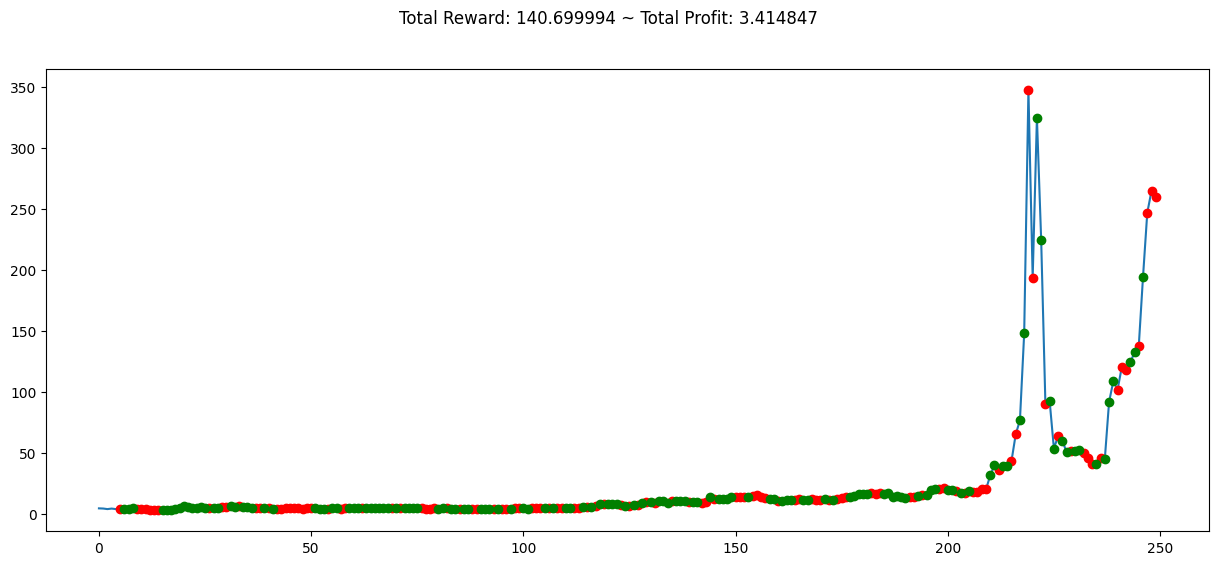

In [6]:
state = env.reset() # Getting the initial state
while True: 
    action = env.action_space.sample() # Randomy buying or selling GME shares 
    n_state, reward, done, truncated, info = env.step(action)  # Taking random steps in the environment, taking the action and applying it to the environment
    if done or truncated: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all() # Renders all the trades that happend in our environment
plt.show()

## Add Custom Indicators

Trading indicators are mathematical computations plotted as lines on a price chart that aid traders in identifying certain signs and trends in the stock market. 
They are simply a set of tools applied to a trading chart to demystify the market and make a clearer analysis.

### &emsp; 1- Fix Volumne Column

In [7]:
# The volume column is a number but after displaying the dtypes we will get an object (this issue depends on the dataset used)
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [8]:
# The problem is we will not be able to calculate the OBV since we need the Volume column to be a number
# Values are wrapped within strings
df['Volume'].unique()

array(['4,866,696', '3,562,210', '3,651,709', '5,039,539', '7,722,194',
       '6,009,784', '6,805,659', '3,592,059', '6,210,979', '7,024,763',
       '3,350,571', '2,304,132', '4,568,695', '4,064,339', '3,830,761',
       '3,331,070', '2,836,859', '2,884,528', '5,908,916', '6,844,501',
       '13,506,630', '7,499,854', '3,371,921', '5,653,188', '6,085,011',
       '4,142,050', '2,678,133', '2,265,853', '2,236,544', '7,275,138',
       '5,200,189', '3,370,045', '2,173,530', '4,005,598', '4,068,105',
       '2,105,919', '3,369,640', '2,501,195', '2,353,661', '1,699,158',
       '2,639,157', '2,882,877', '2,004,868', '1,940,704', '2,371,694',
       '1,840,732', '2,543,609', '1,971,906', '2,379,851', '3,545,926',
       '3,146,603', '2,184,367', '3,973,540', '2,618,424', '2,369,780',
       '3,037,424', '3,514,299', '6,274,428', '10,133,660', '8,073,448',
       '10,606,370', '6,235,993', '4,378,192', '3,910,385', '3,123,535',
       '3,593,466', '3,423,827', '7,365,867', '3,178,966', '3

In [9]:
# Converting the Volume column to float
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

### &emsp; 2- Calculate SMA, RSI and OBV

In [10]:
# Calculating all the indicators that are going to be applied to the environment
df['SMA'] = TA.SMA(df, 12) # 12 period simple moving average
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4866696.0,0.0,0.000000,0.0
2020-03-17,4.40,4.65,4.11,4.23,3562210.0,0.0,0.000000,-3562210.0
2020-03-18,4.10,4.25,3.50,3.77,3651709.0,0.0,0.000000,-7213919.0
2020-03-19,3.71,4.20,3.55,4.19,5039539.0,0.0,43.394834,-2174380.0
2020-03-20,4.08,4.08,3.65,3.76,7722194.0,0.0,29.351457,-9896574.0


### &emsp; 3- Create New Environments

In [11]:
# Values of window_size and frame_bound can be changed (respect the rules)
myenv = MyStocksEnv(df=df, window_size=12, frame_bound=(12,50))
myenv

In [12]:
myenv.signal_features # The features that we are going to use to train our model

array([[ 3.90000000e+00,  4.86669600e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.11000000e+00,  3.56221000e+06,  0.00000000e+00,
         0.00000000e+00, -3.56221000e+06],
       [ 3.50000000e+00,  3.65170900e+06,  0.00000000e+00,
         0.00000000e+00, -7.21391900e+06],
       [ 3.55000000e+00,  5.03953900e+06,  0.00000000e+00,
         4.33948339e+01, -2.17438000e+06],
       [ 3.65000000e+00,  7.72219400e+06,  0.00000000e+00,
         2.93514572e+01, -9.89657400e+06],
       [ 3.50000000e+00,  6.00978400e+06,  0.00000000e+00,
         3.21029638e+01, -3.88679000e+06],
       [ 3.89000000e+00,  6.80565900e+06,  0.00000000e+00,
         4.75129499e+01,  2.91886900e+06],
       [ 4.04000000e+00,  3.59205900e+06,  0.00000000e+00,
         4.78769470e+01,  6.51092800e+06],
       [ 4.24000000e+00,  6.21097900e+06,  0.00000000e+00,
         5.57995572e+01,  1.27219070e+07],
       [ 4.15000000e+00,  7.02476300e+06,  0.00000000e+00,
         4.93981406e+01

In [13]:
myenv.prices # The prices that we are going to use to train our model

array([3.9 , 4.11, 3.5 , 3.55, 3.65, 3.5 , 3.89, 4.04, 4.24, 4.15, 3.65,
       3.5 , 3.12, 2.85, 2.57, 2.83, 3.1 , 3.2 , 3.49, 4.16, 5.14, 4.9 ,
       4.88, 4.43, 4.78, 4.76, 4.83, 4.58, 4.66, 4.81, 5.06, 5.45, 5.64,
       5.45, 5.4 , 5.35, 4.9 , 4.65, 4.82, 4.75, 4.46, 4.07, 3.96, 4.04,
       4.36, 4.37, 4.34, 4.4 , 4.13, 4.33])

## Build Environment and Train using Stable Base Lines 3

In [14]:
# Wrapping the env in a vectorized env
env_maker = lambda: myenv
env = DummyVecEnv([env_maker])

In [15]:
# First version of stop model training callback

# from stable_baselines3.common.callbacks import BaseCallback
# from sklearn.metrics import explained_variance_score
# import numpy as np

# class StopTrainingOnHighExplainedVariance(BaseCallback):
#     """
#     Custom callback that stops training when the explained variance is near one.
#     """
#     def __init__(self, check_freq: int, verbose=0):
#         super(StopTrainingOnHighExplainedVariance, self).__init__(verbose)
#         self.check_freq = check_freq
#         self.explained_variance_threshold = 0.9

#     def _on_step(self) -> bool:
#         """
#         This method will be called by the model after each call to `env.step()`.
#         """
#         if self.n_calls % self.check_freq == 0:
#             # Get the current rewards and predicted values
#             rewards = np.array(self.model.rollout_buffer.rewards)
#             values = np.array(self.model.rollout_buffer.values).flatten()
#             # Compute the explained variance
#             explained_variance = explained_variance_score(rewards, values)
#             # Stop training if the explained variance is above the threshold
#             if explained_variance >= self.explained_variance_threshold:
#                 print(f"Stopping training because explained variance {explained_variance} is above threshold {self.explained_variance_threshold}")
#                 return False
#         return True

# # Create the callback
# # check_freq = 1000
# check_freq = 10
# callback = StopTrainingOnHighExplainedVariance(check_freq=check_freq)

# # In this code, check_freq is the number of steps between each computation of the explained variance. 
# # It's set to 1000, which means the explained variance is computed every 1000 steps. 
# # This can reduce the computational overhead of the callback, especially for large environments or long training runs


In [16]:
# Second version of stop model training callback

from stable_baselines3.common.callbacks import BaseCallback
from sklearn.metrics import explained_variance_score
import numpy as np
import time

class StopTrainingOnHighExplainedVariance(BaseCallback):
    """
    Custom callback that stops training when the explained variance is near one or when a time limit is exceeded.
    """
    def __init__(self, check_freq: int, time_limit: int, verbose=0):
        super(StopTrainingOnHighExplainedVariance, self).__init__(verbose)
        self.check_freq = check_freq
        self.time_limit = time_limit
        self.explained_variance_threshold = 0.9
        self.start_time = time.time()

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.
        """
        if self.n_calls % self.check_freq == 0 :
            # Get the current rewards and predicted values
            rewards = np.array(self.model.rollout_buffer.rewards)
            values = np.array(self.model.rollout_buffer.values).flatten()
            # Compute the explained variance
            explained_variance = explained_variance_score(rewards, values)
            # Stop training if the explained variance is above the threshold
            if explained_variance >= self.explained_variance_threshold:
                print(f"Stopping training because explained variance {explained_variance} is above threshold {self.explained_variance_threshold}")
                return False
            # Stop training if time limit is exceeded
            if (time.time() - self.start_time) > self.time_limit:
                print(f"Stopping training because time limit of {self.time_limit} seconds has been exceeded")
                return False
        return True

# Create the callback
check_freq = 10
# time_limit = 3600  # One hour
time_limit = 60  # One minute
callback = StopTrainingOnHighExplainedVariance(check_freq=check_freq, time_limit=time_limit)

In [17]:
# Training the model
model = A2C('MlpPolicy', env, verbose=1) # specifying the policy: MlpLstmPolicy multi layer perceptron lstm policy (we will be using a deep neural network which has a lstm layer)
                                             
# (optionally we can configure a callback function to stop the model when we hit a certain level of accuracy)
model.learn(total_timesteps=1000000, callback=callback) # Training the model for 1 million time steps
                                                        # We need to pay attention to explained variance value we need it to be as close to 1 as possible
                                                        # The closer to one the more the model begun to learn the difference variances in the data and now start to understand the patterns in the data.
                                     

Using cpu device


------------------------------------
| time/                 |          |
|    fps                | 584      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.679   |
|    explained_variance | -5.57    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0708  |
|    value_loss         | 0.0164   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 597      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.688   |
|    explained_variance | -0.809   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.128    |
|    value_loss         | 0.0603   |
-

## Evaluation

In [23]:
env = MyStocksEnv(df=df, window_size=12, frame_bound=(80,120))
obs, info = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, truncated,  info = env.step(action)
    if done or truncated:
        print("info", info)
        break

info {'total_reward': 0.6299999999999999, 'total_profit': 1.3819303397249114, 'position': <Positions.Long: 1>}


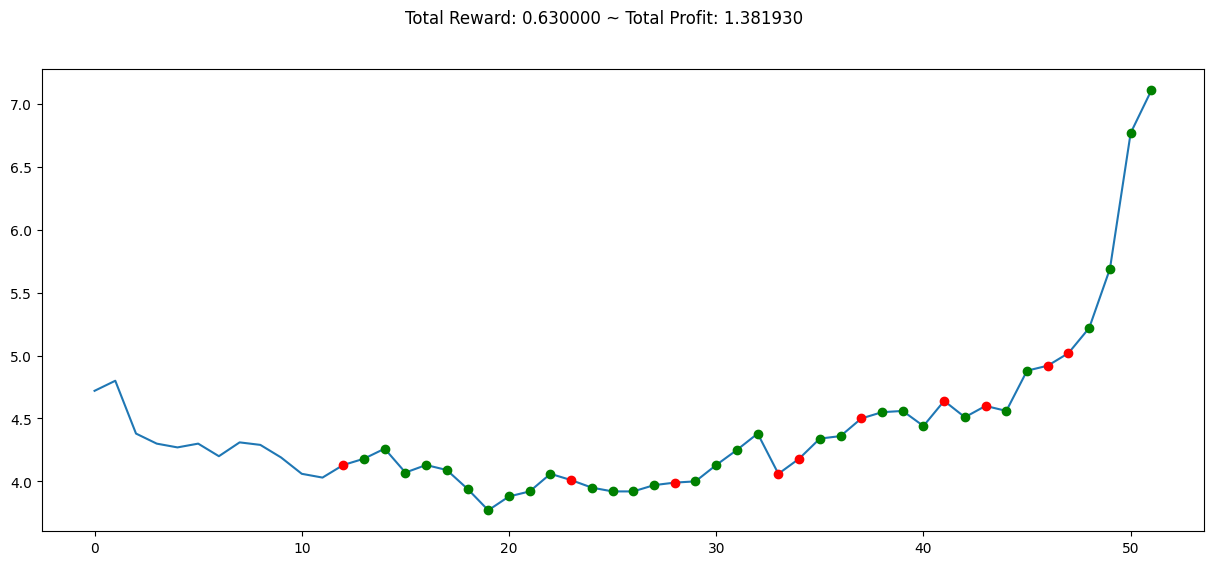

In [24]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()